# Anomaly Detection using Computer Vision

The purpose of anomaly detection via computer vision is to identify and flag instances in visual data that deviate significantly from what is considered normal or expected. *Anomalies*, also known as *outliers*, are data points or patterns that differ substantially from the majority of the data, either due to errors, defects, fraud, or any other unusual circumstances. Anomaly detection in computer vision involves leveraging machine learning and image processing techniques to automatically identify such anomalies in images or videos.

Some common applications and use-cases for anomaly detection via computer vision include:

**Quality Control and Defect Detection**: In manufacturing industries, computer vision can be used to inspect products for defects, such as scratches, dents, or missing parts. Any products that don't meet the expected standards can be flagged as anomalies.

**Security and Surveillance**: Anomaly detection is used in security systems to detect unusual activities in surveillance videos. This could involve identifying unauthorized personnel in restricted areas, unusual object placement, or abnormal behavior patterns.

**Medical Imaging**: Medical imaging technologies like X-rays, MRIs, and CT scans can be used to detect anomalies in human tissues or organs. This can help in early detection of diseases or abnormalities.

**Predictive Maintenance**: In industrial settings, computer vision can monitor equipment and machinery for signs of wear and tear. Anomalies in machine behavior can be indicative of potential breakdowns, allowing for preemptive maintenance.

**Traffic Monitoring**: Anomaly detection in traffic monitoring can identify unusual traffic patterns, accidents, or congestion in real time, enabling better traffic management.

**Environmental Monitoring**: In environmental monitoring, computer vision can detect unusual behavior in natural habitats, such as identifying changes in animal behavior or spotting forest fires.

**Agriculture**: Computer vision can help detect anomalies in crops, such as identifying plant diseases or pest infestations.

The main advantage of using computer vision for anomaly detection is its ability to process large volumes of visual data quickly and consistently, allowing for the detection of anomalies in real time. It reduces the need for manual inspection and can catch anomalies that might be missed by human observers. However, setting up effective anomaly detection systems requires careful training of machine learning models and robust validation to minimize false positives and false negatives.

In this notebook, we go through the process of applying anomaly detection for the purposes of quality control and defect detection (use-case one).

## Introduction to Anomalib

There are several frameworks and libraries available for implementing anomaly detection using computer vision techniques like OpenCV, Scikit-image, Mahotas, Detectron2 and many others. In this notebook we use [Anomalib](https://github.com/openvinotoolkit/anomalib/tree/main), a comprehensive deep learning library designed to serve as a hub for state-of-the-art anomaly detection algorithms. 

The library is particularly geared towards image-based anomaly detection, with the primary goal of identifying anomalous images or abnormal pixel regions within images in a dataset. It is particularly well suited for our purposes because it offers a collection of ready-to-use implementations while also supports the implementation of custom models. Some of the key features of Anomalib include:

* The largest public collection of ready-to-use deep learning anomaly detection algorithms and benchmark datasets.
* [PyTorch Lightning](https://www.pytorchlightning.ai/) based model implementations to reduce boilerplate code and limit the implementation efforts to the bare essentials.
* All models can be exported to [OpenVINO](https://www.intel.com/content/www/us/en/developer/tools/openvino-toolkit/overview.html) Intermediate Representation (IR) for accelerated inference on intel hardware.
* A set of inference tools for quick and easy deployment of the standard or custom anomaly detection models.

Let's start by importing all the classes and functions from PyTorch Lightning and Anomalib that we'll need in the notebook.

In [26]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [27]:
import os

from pytorch_lightning import Trainer

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import LoadModelCallback
from anomalib.utils.callbacks import get_callbacks
from anomalib.data.utils import read_image

from anomalib.deploy import OpenVINOInferencer

from matplotlib import pyplot as plt

Anomalib provides ready implementation for a wide range of models like CFA, CFlow, FastFlow, GANomaly, PaDiM and more. Each model has its own `config.yaml` configuration file, which contains data, model and training configurable parameters, and is specific for the model and the corresponding dataset.

In this notebook we use [PaDiM](https://arxiv.org/abs/2011.08785): a Patch Distribution Modeling Framework for Anomaly Detection and Localization. The project already contains the relevant configuration file for this model - `padim_config.yaml`. PaDiM is a patch based algorithm. It relies on a pre-trained CNN feature extractor. The image is broken into patches and embeddings are extracted from each patch using different layers of the feature extractors.

Let's process it and print its contents.

In [28]:
current_directory = os.getcwd()

config_file = os.path.join(current_directory, "padim_config.yaml")

with open(file=config_file, mode="r", encoding="utf-8") as file:
    print(file.read())

dataset:
  name: mvtec
  format: mvtec
  path: ./datasets/MVTec
  category: metal_nut
  task: segmentation
  train_batch_size: 32
  eval_batch_size: 32
  num_workers: 8
  image_size: 256 # dimensions to which images are resized (mandatory)
  center_crop: null # dimensions to which images are center-cropped after resizing (optional)
  normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
  transform_config:
    train: null
    eval: null
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.2 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_test, from_test, synthetic]
  val_split_ratio: 0.5 # fraction of train/test images held out for validation (usage depends on val_split_mode)
  tiling:
    apply: false
    tile_size: null
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_tile_count: 16

model:
  

You can notice above that the file also contains settings specific to the location and format of the training data. This leads us to the dataset we use in this project.

## MVTecAD Anomaly Detection Dataset

The [MVTec AD dataset](https://openaccess.thecvf.com/content_CVPR_2019/papers/Bergmann_MVTec_AD_--_A_Comprehensive_Real-World_Dataset_for_Unsupervised_Anomaly_CVPR_2019_paper.pdf) is designed for evaluating anomaly detection methods in industrial inspection. It includes 5000+ high-res images grouped into 15 object and texture categories. Categories have defect-free training images and test images with defects. Two main metrics are Detection AUROC and Segmentation AUROC. Detection methods produce anomaly scores for test images, while segmentation methods provide anomaly probabilities for each pixel. Segmentation's performance is evaluated by comparing its region overlap with ground truth, and an independent metric called ROC AUC.

For this notebook we focus on the defects on metal nuts category. We start by parsing the model configuration, and overriding some of the default values.

In [29]:
config = get_configurable_parameters(config_path=config_file)

In [30]:
# Focus on the metal nut category
config.dataset.category="metal_nut"

# Configure the data loader
config.dataset.num_workers=0
config.dataset.train_batch_size=16
config.dataset.test_batch_size=16

# Set the seed for reproducibility purposes
config.project.seed=1234

# Set the output path
# Please change this location accordingly
config.project.path="/mnt/artifacts/padim/mvtec/mteal_nut/run"

# We set the optimiser to OpenVINO
config.optimization.export_mode = "openvino"

The MVTecAD dataset is quite large. Trying to store it in DFS or Git would be impractical. 
Instead, we can use [Domino Datasets](https://docs.dominodatalab.com/en/latest/user_guide/0a8d11/datasets/), which are ideally suited for this task.

In [31]:
config.dataset.path = os.path.join(os.environ["DOMINO_DATASETS_DIR"], os.environ["DOMINO_PROJECT_NAME"])

# Please ensure that the directory printed exists and is accessible
print("Data will be stored under {}".format(config.dataset.path))

Data will be stored under /mnt/data/anamoly


In [32]:
# Get Anomaly Datamodule
datamodule = get_datamodule(config)

We now need to download about 5.26 GB of data and unpack it. This may take a while.

In [33]:
datamodule.prepare_data()

# Download the dataset if not available

datamodule.setup()

Let's look at the dataset keys to confirm everything is in order.

In [34]:
i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())

dict_keys(['image_path', 'label', 'image', 'mask_path', 'mask'])


Let's plot some of the training images to get a sense of what data we are dealing with.

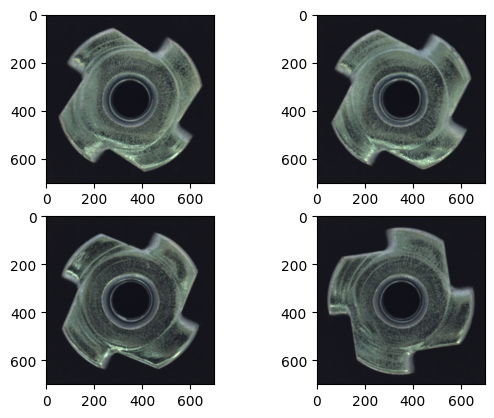

In [35]:
image_path = os.path.join(config.dataset.path, "metal_nut", "train", "good")

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(read_image(path=os.path.join(image_path, "000.png")))
axarr[0,1].imshow(read_image(path=os.path.join(image_path, "001.png")))
axarr[1,0].imshow(read_image(path=os.path.join(image_path, "002.png")))
axarr[1,1].imshow(read_image(path=os.path.join(image_path, "003.png")));


## Training

Now lets load the model using the configuration and also get the base callbacks for lightning.

In [36]:
model = get_model(config)
callbacks = get_callbacks(config)

FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


We can now train the PaDiM model.

In [37]:
trainer = Trainer(**config.trainer, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AnomalyScoreThreshold    | 0     
1 | pixel_threshold       | AnomalyScoreThreshold    | 0     
2 | model                 | PadimModel               | 2.8 M 
3 | image_metrics         | AnomalibMetricCollection | 0     
4 | pi

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai/2023.0/openvino_2_0_transition_guide.html
[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /mnt/artifacts/padim/mvtec/mteal_nut/run/weights/openvino/model.xml
[ SUCCESS ] BIN file: /mnt/artifacts/padim/mvtec/mteal_nut/run/weights/openvino/model.bin


Inference

In [38]:
model_path = os.path.join(config.project.path, "weights", "openvino", "model.bin")
model_metadata = os.path.join(config.project.path, "weights", "openvino", "metadata.json")

print("Our model was successfully trained and stored in:", model_path)
print("Model metadata is location in: ", model_metadata)

Our model was successfully trained and stored in: /mnt/artifacts/padim/mvtec/mteal_nut/run/weights/openvino/model.bin
Model metadata is location in:  /mnt/artifacts/padim/mvtec/mteal_nut/run/weights/openvino/metadata.json


## Inference

Now let's see how we can use the trained model to do some inference.

First, let's make sure that the *model.bin* and corresponding metadata file exist.

In [39]:
print(os.path.isfile(model_path), os.path.isfile(model_metadata))

True True


Next, let's see some images that exhibit anomalies.

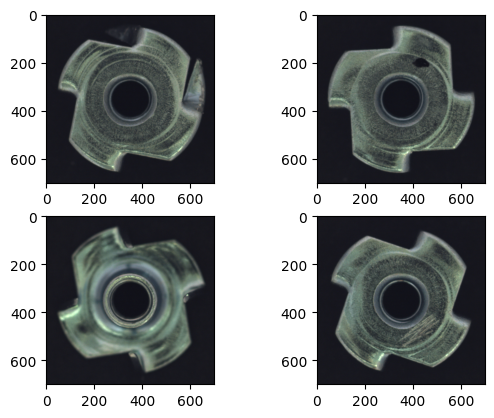

In [40]:
image_path = os.path.join(config.dataset.path, "metal_nut", "test")

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(read_image(path=os.path.join(image_path, "bent/000.png")))
axarr[0,1].imshow(read_image(path=os.path.join(image_path, "color/000.png")))
axarr[1,0].imshow(read_image(path=os.path.join(image_path, "flip/000.png")))
axarr[1,1].imshow(read_image(path=os.path.join(image_path, "scratch/000.png")));

The [OpenVINO Runtime](https://docs.openvino.ai/2023.0/openvino_docs_OV_UG_OV_Runtime_User_Guide.html) is a collection of C++ libraries with bindings for C and Python. It offers a unified API for deploying inference solutions on various platforms. This API allows you to load models in different formats like IR, TensorFlow, TensorFlow Lite, ONNX, or PaddlePaddle and run them on your preferred devices.

The OpenVINO Runtime provides various inference modes to ensure efficient hardware usage in different scenarios. The simplest mode is the single-device mode, where a single device handles the entire inference workload. This mode is compatible with a variety of Intel hardware, utilizing specialized plugins within the Runtime library for optimized performance. To learn more about the supported devices and how to utilize them, consult the [guide on inference devices](https://docs.openvino.ai/2023.0/openvino_docs_OV_UG_Working_with_devices.html).

In [41]:
inferencer = OpenVINOInferencer(
    path=model_path, 
    metadata=model_metadata, 
    device="CPU"
)

Let's try one of the anomalous images.

In [42]:
image_path = os.path.join(config.dataset.path, "metal_nut", "test", "bent", "000.png")

In [43]:
predictions = inferencer.predict(image=image_path)

In [44]:
print("Prediction score: ", predictions.pred_score)
print("Prediction label: ", predictions.pred_label)

Prediction score:  0.9758429280508507
Prediction label:  True


Let's look at the image that was just scored.

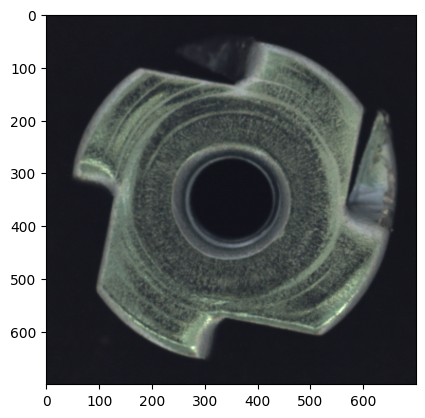

In [45]:
plt.imshow(predictions.image);

Anomalib also provides an Anomaly Map Generator for the PaDiM model implementation.

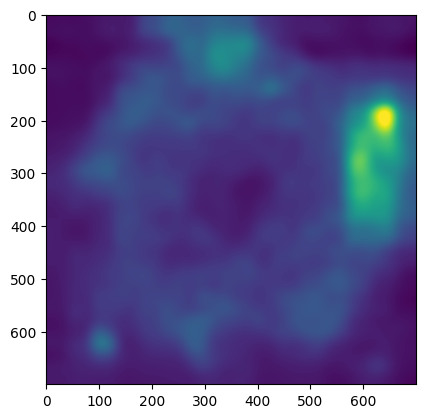

In [46]:
plt.imshow(predictions.anomaly_map);

Recall that PaDIM is a patch based algorithm. This is generally a segmentation type of model, so we can also visualise the specific areas of the image that exhibit anomalies.

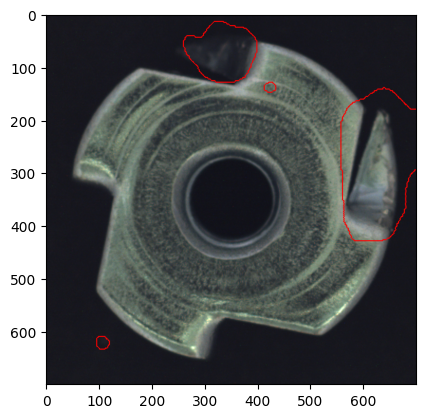

In [47]:
plt.imshow(predictions.segmentations)